In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

In [3]:
norm = False # NORMALIZATION
scaler = StandardScaler()

# Model choice
models = ['use', 'stf', 'fasttext', 'glove', 'elmo']
model = models[4]
print(f'Using {model.upper()} model')

# Load the data
scores_df = pd.read_csv(f'/content/drive/MyDrive/STS Measures/scores/{model}_scores.csv', low_memory=False)
model_goals = pd.read_csv(f'/content/drive/MyDrive/STS Measures/scores/{model}_goals.csv', low_memory=False)
goals_df = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/gpt_goals.csv', low_memory=False)

# print(scores_df.head())
# print(goals_df.head())

Using ELMO model


In [4]:
# Check for missing values
# print(scores_df.isnull().sum())
# print(goals_df.isnull().sum())

# Drop missing values as needed ## Redundant Step
scores_df = scores_df.dropna(subset=['Title', 'Abstract'])

# Convert similarity scores to numeric (if not already) ## Redundant Step
similarity_columns = [col for col in scores_df.columns if 'Goal_' in col]
scores_df[similarity_columns] = scores_df[similarity_columns].apply(pd.to_numeric, errors='coerce')

In [5]:
if norm:
  scores_df[similarity_columns] = scaler.fit_transform(scores_df[similarity_columns])

In [6]:
scores_df[similarity_columns].head()

# Remove _Similarity from column names that are in
scores_df.columns = scores_df.columns.str.replace('_Similarity', '')
model_goals.columns = model_goals.columns.str.replace('_Similarity', '')
similarity_columns = [col.replace('_Similarity', '') for col in similarity_columns]

In [7]:
average_similarity = (scores_df[similarity_columns].mean()).sort_values(ascending=False)
print(average_similarity)

Goal_12    0.694476
Goal_11    0.676972
Goal_7     0.675992
Goal_9     0.669242
Goal_17    0.664794
Goal_13    0.651830
Goal_6     0.650827
Goal_15    0.639187
Goal_2     0.621967
Goal_14    0.619040
Goal_3     0.598823
Goal_10    0.593735
Goal_16    0.588396
Goal_8     0.585561
Goal_1     0.581097
Goal_4     0.573491
Goal_5     0.556929
dtype: float64


In [8]:
scores_df['Average_Similarity'] = scores_df[similarity_columns].mean(axis=1)
top_5_papers = scores_df.nlargest(5, 'Average_Similarity')
print(top_5_papers[['Title', 'Average_Similarity']])

                                                   Title  Average_Similarity
20126  Study on the Potential of Virtual Power Plants...            0.817054
16152  Eco-Friendly Geopolymer Concrete: A Critical R...            0.802207
3980   Evaluation of Modern Smart Cities in South Asi...            0.797725
12931  Centering Meaning-Filled Design Within Enginee...            0.796191
18546  Design and Simulation of a Silicon Carbide MOS...            0.795594


# Max and Min Similarity

In [9]:
scores_df['Min_Similarity'] = scores_df[similarity_columns].min(axis=1)
scores_df['Max_Similarity'] = scores_df[similarity_columns].max(axis=1)

# Identify the corresponding goals for these minimum and maximum scores
scores_df['Min_Similarity_Goal'] = scores_df[similarity_columns].idxmin(axis=1)
scores_df['Max_Similarity_Goal'] = scores_df[similarity_columns].idxmax(axis=1)

In [10]:
scores_df['Min_Similarity_Goal'] = scores_df['Min_Similarity_Goal'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
scores_df['Max_Similarity_Goal'] = scores_df['Max_Similarity_Goal'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])

In [11]:
print(scores_df[['Title', 'Min_Similarity', 'Min_Similarity_Goal', 'Max_Similarity', 'Max_Similarity_Goal']].head())

                                               Title  Min_Similarity  \
0  HOLISTIC ASSESSMENT METHODOLOGY FOR POSITIVE E...        0.569546   
1  Sustainability Indicators for Biogas Productio...        0.575664   
2  Having More Access Leads to Better Welfare: St...        0.528770   
3  The Impact and Prevention of the Pandemic Cris...        0.528026   
4  Influence of Microstructural and Geotechnical ...        0.411080   

  Min_Similarity_Goal  Max_Similarity Max_Similarity_Goal  
0              Goal_5        0.767779              Goal_7  
1              Goal_5        0.823855              Goal_7  
2              Goal_5        0.798337             Goal_12  
3              Goal_4        0.685840             Goal_12  
4              Goal_5        0.619774             Goal_12  


In [12]:
# Count the number of records where each goal is the most relevant (maximum similarity)
max_relevant_counts = scores_df['Max_Similarity_Goal'].value_counts()

# Count the number of records where each goal is the least relevant (minimum similarity)
min_relevant_counts = scores_df['Min_Similarity_Goal'].value_counts()

# Combine the results into a single DataFrame
relevance_counts = pd.DataFrame({
    'Most_Relevant_Count': max_relevant_counts,
    'Least_Relevant_Count': min_relevant_counts
}).fillna(0).astype(int)

In [13]:
## Sort the results

# Sort by Count_Difference in descending order
# relevance_counts['Count_Difference'] = relevance_counts['Most_Relevant_Count'] - relevance_counts['Least_Relevant_Count']

relevance_counts = relevance_counts.sort_index(key=lambda x: x.str.split('_').str[-1].astype(int))
# relevance_counts = relevance_counts.sort_values(by='Most_Relevant_Count', ascending=False)
# relevance_counts = relevance_counts.sort_values(by='Least_Relevant_Count', ascending=False)
# relevance_counts = relevance_counts.sort_values(by='Count_Difference', ascending=False)

In [14]:
print(relevance_counts)
relevance_counts.to_csv(f'/content/drive/MyDrive/STS Measures/relevance/{model}_relevance_counts.csv', index=True)

         Most_Relevant_Count  Least_Relevant_Count
Goal_1                    65                  3467
Goal_2                   354                   436
Goal_3                   274                   474
Goal_4                   806                  3783
Goal_5                    56                  9425
Goal_6                   576                     9
Goal_7                  2335                    12
Goal_8                    29                   962
Goal_9                  1386                     1
Goal_10                  216                   374
Goal_11                 2270                     0
Goal_12                 8051                     0
Goal_13                  605                     4
Goal_14                  588                  2943
Goal_15                  722                   133
Goal_16                   29                   401
Goal_17                 4065                     3


# Density Distribution of Goal Scores

In [15]:
# plt.figure(figsize=(10, 5))
# for col in similarity_columns:
#     sns.kdeplot(scores_df[col], label=col)

# plt.xlabel('Similarity Score')
# plt.ylabel('Density')
# plt.title(f'{model.upper()} Distribution of Similarity Scores for Each Goal')
# plt.legend()
# plt.show()

# Pearson Correlation Matrix

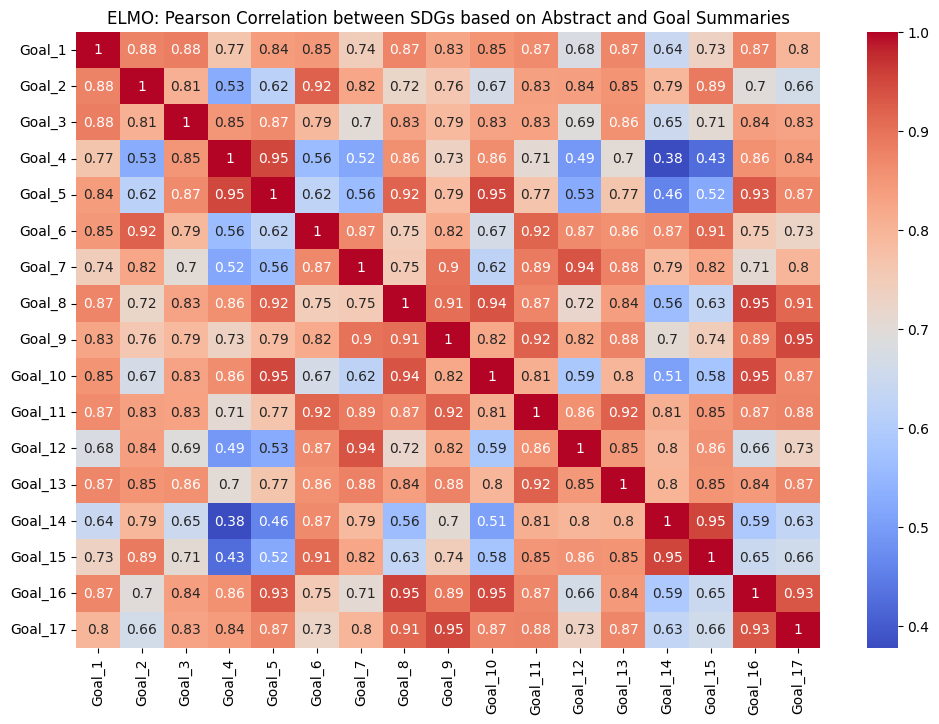

In [16]:
# PEARSON CORRELATION MATRIX
correlation_matrix = scores_df[similarity_columns].corr()
# print(correlation_matrix)
# correlation_matrix.to_csv(f'/content/drive/MyDrive/STS Measures/correlation/{model}_summary_matrix.csv')

# Display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(f'{model.upper()}: Pearson Correlation between SDGs based on Abstract and Goal Summaries')
plt.show()


# Regression Analysis

In [17]:
target = 'Goal_1'
independent_reg = False
reduce_by_vif = False

In [18]:
data = scores_df[similarity_columns].copy()

y = data[target]
X = data.drop([target], axis=1)
X = sm.add_constant(X)

regressor = sm.OLS(y, X).fit()

print(model.upper(),'\n')
print(regressor.summary())

ELMO 

                            OLS Regression Results                            
Dep. Variable:                 Goal_1   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 4.997e+04
Date:                Wed, 17 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:39:14   Log-Likelihood:                 65008.
No. Observations:               22427   AIC:                        -1.300e+05
Df Residuals:                   22410   BIC:                        -1.298e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0064      0.001     -6.674  

In [19]:
if independent_reg:
  rigs = {}
  coefs = {}
  print(model.upper(),'\n')

  # Iterate through each independent variable
  for col in data.drop([target], axis=1):
      # Prepare X with only the current independent variable
      X_single = sm.add_constant(data[col])

      # Fit OLS model
      regressor = sm.OLS(y, X_single).fit()

      # Store the model and coefficients in the dictionary
      rigs[col] = regressor
      coefs[col] = regressor.params[col]

      print(col.upper())
      # print(regressor.summary(),'\n\n')
      print('Coefficient:', coefs[col])
      print('R.sq:', regressor.rsquared)
      print('\n')

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming `X` is your dataframe containing independent variables
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

    feature         VIF
0     const  114.789388
1    Goal_2   19.465462
2    Goal_3   14.156596
3    Goal_4   20.388624
4    Goal_5   48.330399
5    Goal_6   27.446924
6    Goal_7   32.173787
7    Goal_8   30.018336
8    Goal_9   42.719768
9   Goal_10   19.632256
10  Goal_11   22.973358
11  Goal_12   12.975634
12  Goal_13   19.917786
13  Goal_14   16.442482
14  Goal_15   31.181793
15  Goal_16   36.582905
16  Goal_17   41.961730


In [21]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_reduced = X.drop(columns=to_drop)
if reduce_by_vif:
  X = X_reduced

In [22]:
# pca = PCA(n_components=n)
# X_pca = pca.fit_transform(X)
# # Use X_pca in your regression model

In [33]:
reg = 'pls'

regressor_dict = {
    'ridge': Ridge(alpha=0.4), # 0.4
    'lasso': Lasso(alpha=1e-7), # 1e-7 | 2e-5
    'elasticnet': ElasticNet(alpha=2e-7, l1_ratio=0.5), # 2e-7 | 3e-5
    'pls': PLSRegression(n_components=2)
}

regressor = regressor_dict[reg]
regressor.fit(X, y)
coefficients = regressor.coef_.flatten()
rig_score = regressor.score(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [34]:
coef_df = pd.DataFrame({
    'SDG Goal': similarity_columns,
    'Coefficient': coefficients
})

print(reg.upper())
print(coef_df)
print(f"R^2 Score: {rig_score:.4f}")

PLS
   SDG Goal  Coefficient
0    Goal_1     0.000000
1    Goal_2     0.014272
2    Goal_3     0.011345
3    Goal_4     0.008620
4    Goal_5     0.011150
5    Goal_6     0.007785
6    Goal_7    -0.001057
7    Goal_8     0.008125
8    Goal_9     0.001708
9   Goal_10     0.010321
10  Goal_11     0.004020
11  Goal_12    -0.005936
12  Goal_13     0.005850
13  Goal_14    -0.003401
14  Goal_15     0.001462
15  Goal_16     0.008262
16  Goal_17    -0.000226
R^2 Score: 0.8931


# Cosine Similarity Matrix

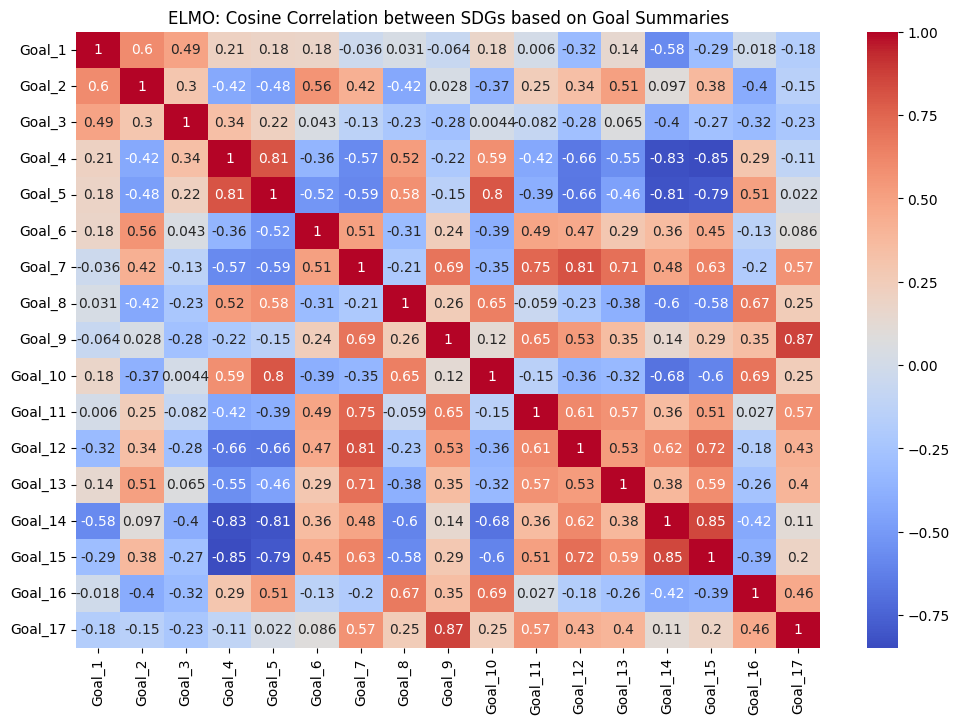

In [ ]:
similarity_columns = [col for col in model_goals.columns if col.startswith('Goal_')]
similarity_columns = [col.replace('_Similarity', '') for col in similarity_columns]

# Compute the correlation matrix
correlation_matrix = model_goals[similarity_columns].corr()
# correlation_matrix.to_csv(f'/content/drive/MyDrive/STS Measures/correlation/{model}_sdg_matrix.csv')

# Normalize the scores
if norm:
  model_goals[similarity_columns] = scaler.fit_transform(model_goals[similarity_columns])

# Display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(f'{model.upper()}: Cosine Correlation between SDGs based on Goal Summaries')
plt.show()

# Experimental

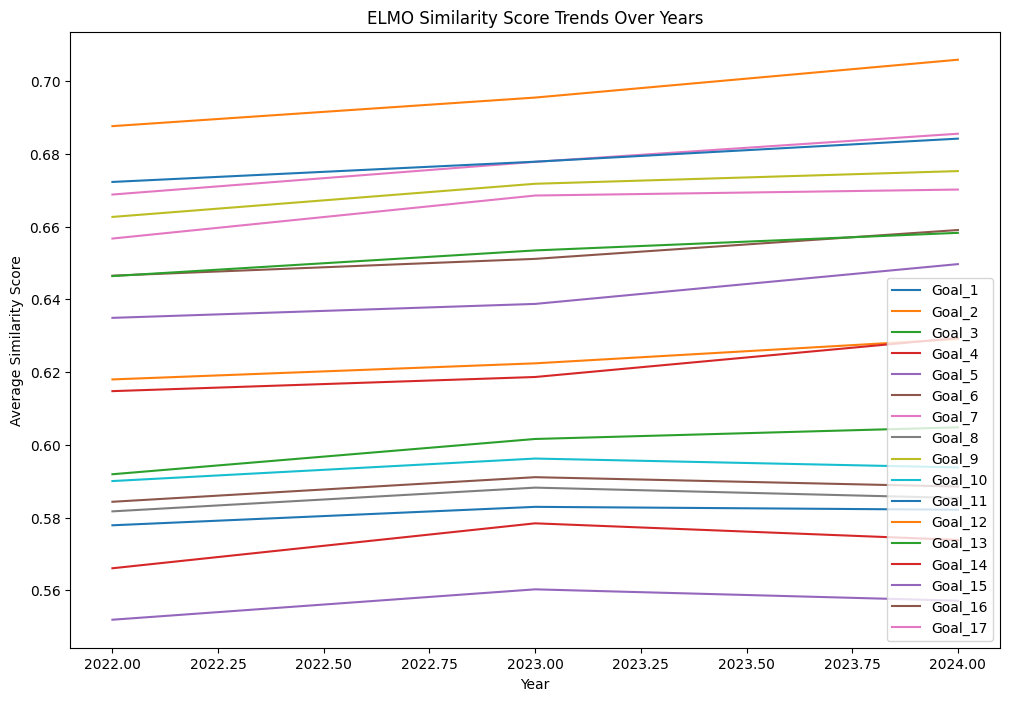

In [ ]:
scores_df['Year'] = pd.to_numeric(scores_df['Year'], errors='coerce')
yearly_similarity = scores_df.groupby('Year')[similarity_columns].mean()

plt.figure(figsize=(12, 8))
for col in similarity_columns:
    plt.plot(yearly_similarity.index, yearly_similarity[col], label=col)

plt.xlabel('Year')
plt.ylabel('Average Similarity Score')
plt.title(f'{model.upper()} Similarity Score Trends Over Years')
plt.legend()
plt.show()


# Experimental

In [ ]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import LassoCV, ElasticNetCV

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Ridge Regression with cross-validation to find the best alpha
# alphas = np.logspace(-10, 0, 1000)
# ridge_cv = RidgeCV(alphas=alphas, cv=5)
# ridge_cv.fit(X, y)
# print("Best alpha for RidgeCV:", ridge_cv.alpha_)

# # LassoCV with cross-validation to find the best alpha
# lasso_cv = LassoCV(alphas=np.logspace(-10, 0, 1000), cv=5)
# lasso_cv.fit(X, y)
# print("Best alpha for LassoCV:", lasso_cv.alpha_)
# print("LassoCV coefficients:", lasso_cv.coef_)

# # ElasticNetCV with cross-validation to find the best alpha and l1_ratio
# elastic_net_cv = ElasticNetCV(alphas=np.logspace(-10, 0, 1000), l1_ratio=0.5, cv=5)
# elastic_net_cv.fit(X, y)
# print("Best alpha for ElasticNetCV:", elastic_net_cv.alpha_)
# print("ElasticNetCV coefficients:", elastic_net_cv.coef_)